In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import logging
from scipy.stats import t, zscore
import scipy.stats as stats
import pylab

In [ ]:
class SalesPerformancePrediction:
    def __init__(self):
        self.label_encoders = {}
        self.models = {}
        self.scaler = StandardScaler()

    def fetch_data_from_sql(self, query, server, database):
        """
        Fetch data from SQL Server using SQLAlchemy
        """
        logging.info("Fetching data from SQL Server...")
        engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")
        data = pd.read_sql_query(query, engine)
        return data

    def prepare_data(self, fact_sales, dim_product, dim_date, dim_territory):
        """
        Merge dimension tables with fact_sales and calculate metrics
        """
        logging.info("Merging dimension tables with fact_sales...")
        sales_data = fact_sales.merge(dim_product, on='ProductKey')\
                            .merge(dim_date, on='DateKey')\
                            .merge(dim_territory, on='TerritoryKey')


        # Handle missing and invalid values
        logging.info("Handling missing and invalid values...")
        sales_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        sales_data.fillna(0, inplace=True)


        # Remove outliers
        logging.info("Removing outliers...")
        sales_data['Revenue'] = sales_data['OrderQty'] * sales_data['UnitPrice']
        sales_data = sales_data[(np.abs(zscore(sales_data['Revenue'])) < 3)]
        sales_data = sales_data.drop(['Revenue'], axis=1)

        return sales_data

In [ ]:
# Database Connection Details
server = "DESKTOP-TGOL65T"
database = "CompanyXdwh_real"

# Queries
fact_sales_query = "SELECT * FROM fact_sales"
dim_product_query = "SELECT * FROM dim_product"
dim_date_query = "SELECT * FROM dim_date"
dim_territory_query = "SELECT * FROM dim_territory"

# Initialize Class
prediction = SalesPerformancePrediction()

# Fetch Data
fact_sales = prediction.fetch_data_from_sql(fact_sales_query, server, database)
dim_product = prediction.fetch_data_from_sql(dim_product_query, server, database)
dim_date = prediction.fetch_data_from_sql(dim_date_query, server, database)
dim_territory = prediction.fetch_data_from_sql(dim_territory_query, server, database)

# Prepare Data
sales_data = prediction.prepare_data(fact_sales, dim_product, dim_date, dim_territory)

In [ ]:
sales_data['datetime'] = pd.to_datetime(sales_data[['Year', 'Month', 'Day']])
sales_data = sales_data.drop(['SalesOrderID', 'ModifiedDate', 'Name',
       'TerritoryID', 'Group', 'ModifiedDate_x', 'ProductID', 'ProductName', 'SalesKey', 'ProductKey', 'DateKey', 'TerritoryKey',
       'StoreKey', 'CustomerKey', 'Day', 'Week', 'Month', 'Quarter', 'Year', 'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'ModifiedDate_y',], axis=1)

In [52]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [53]:
categories = sales_data['Category'].unique()
categories.size

4

In [54]:
sales_data_category = {category: sales_data[sales_data['Category'] == category] for category in categories}


sales_data_category[categories[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06
...,...,...,...,...,...,...,...,...
2014-05-30,1,539.9900,539.9900,639.1983,Bikes,United Kingdom,5.012905e+06,1.635823e+06
2014-05-30,1,2384.0700,2384.0700,2673.0613,Bikes,Germany,3.805202e+06,1.307950e+06
2014-05-30,1,2384.0700,2384.0700,2634.3974,Bikes,Australia,5.977815e+06,2.278549e+06


In [55]:
def train_test_split_category(sales_data_category):
    combine_train_test = {
        category: data['LineTotal'].resample('ME').sum() for category, data in sales_data_category.items()
    }
    
    
    train_monthly_sales_by_category = {
        category: data['LineTotal'].resample('ME').sum()[:-6] for category, data in sales_data_category.items()
    }
    
    test_monthly_sales_by_category = {
        category: data['LineTotal'].resample('ME').sum()[-6:] for category, data in sales_data_category.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_category, test_monthly_sales_by_category)

In [56]:
# Resample 'LineTotal' for each category in the dictionary
combined_data, train_data, test_data = train_test_split_category(sales_data_category)

# Example: Access the resampled data for the first category
first_category = categories[0]
print(f"Monthly sales for category '{first_category}':")
print(train_data[first_category]) 

Monthly sales for category 'Bikes':
datetime
2011-05-31    2.837037e+05
2011-06-30    4.589108e+05
2011-07-31    1.193085e+06
2011-08-31    1.332676e+06
2011-09-30    5.020738e+05
2011-10-31    2.131871e+06
2011-11-30    7.378398e+05
2011-12-31    1.040555e+06
2012-01-31    2.257282e+06
2012-02-29    1.088960e+06
2012-03-31    1.639494e+06
2012-04-30    1.281013e+06
2012-05-31    1.763563e+06
2012-06-30    2.428146e+06
2012-07-31    1.917286e+06
2012-08-31    1.486989e+06
2012-09-30    2.194393e+06
2012-10-31    1.669798e+06
2012-11-30    1.413354e+06
2012-12-31    2.011027e+06
2013-01-31    1.591467e+06
2013-02-28    1.451283e+06
2013-03-31    2.300727e+06
2013-04-30    1.769287e+06
2013-05-31    1.727874e+06
2013-06-30    2.726723e+06
2013-07-31    2.585219e+06
2013-08-31    2.079219e+06
2013-09-30    2.851292e+06
2013-10-31    3.263534e+06
2013-11-30    2.635099e+06
Freq: ME, Name: LineTotal, dtype: float64


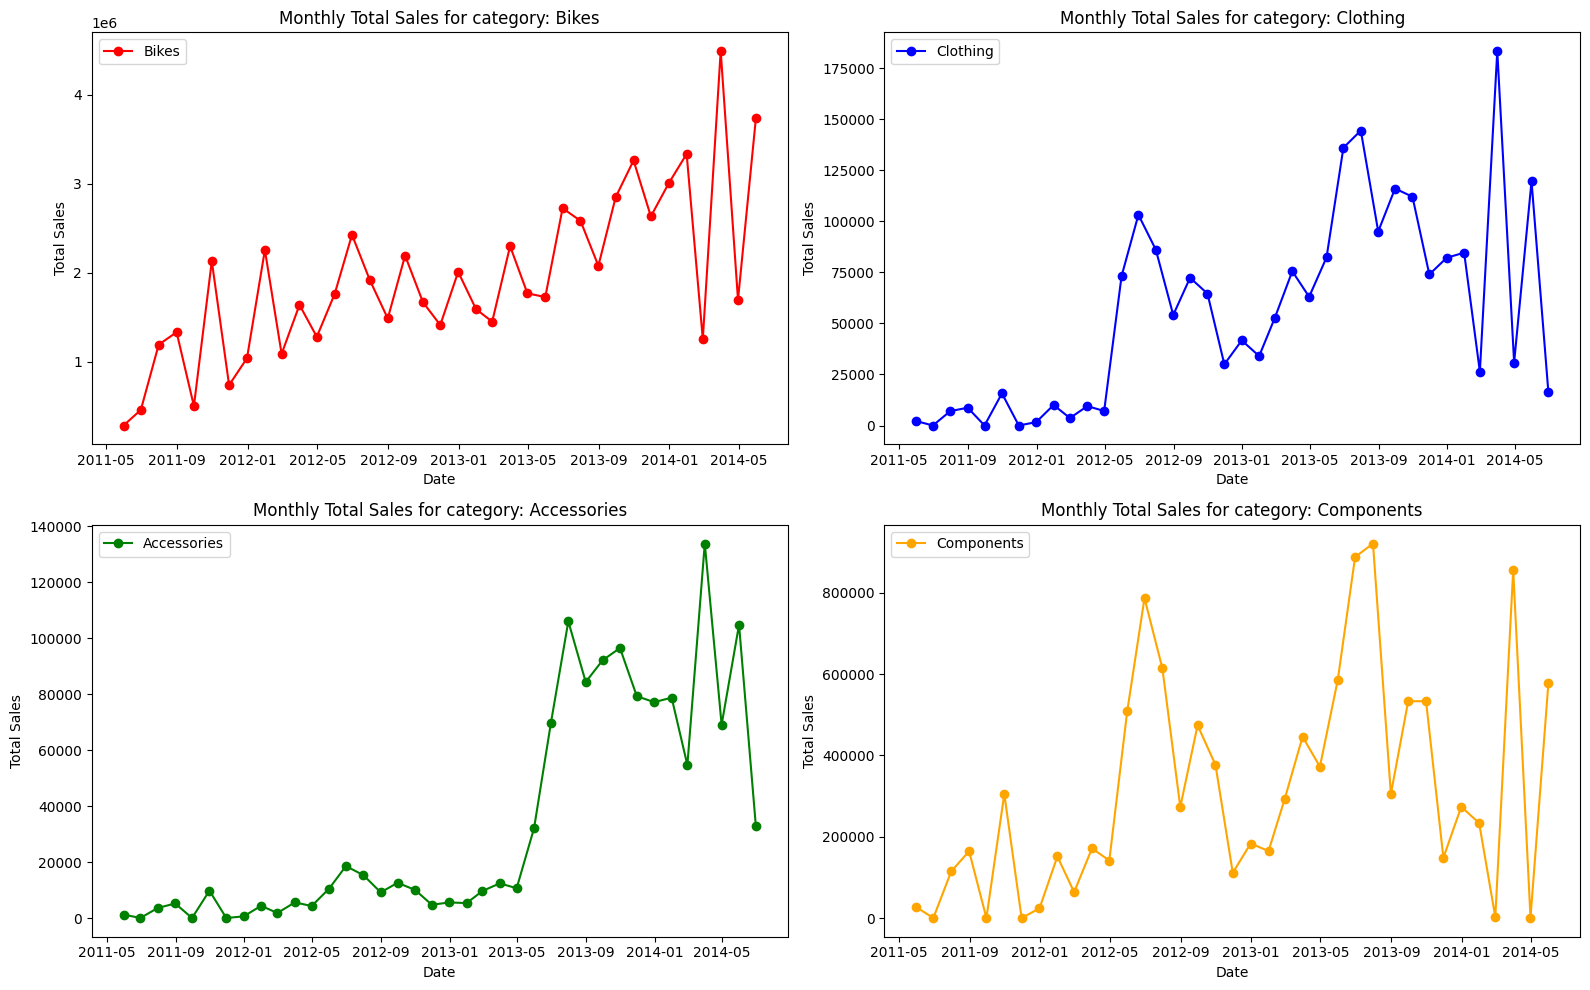

In [57]:
colors = ['red', 'blue', 'green', 'orange']  # Define custom colors
n_categories = len(combined_data)  # Total number of categories
rows, cols = 2, 2  # 2x2 grid for 4 categories

fig, axes = plt.subplots(rows, cols, figsize=(16, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (category, monthly_sales) in enumerate(combined_data.items()):
    ax = axes[i]
    ax.plot(monthly_sales, marker='o', linestyle='-', color=colors[i], label=category)
    ax.set_title(f"Monthly Total Sales for category: {category}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Sales")
    ax.legend(loc='upper left')


# Remove any unused subplots if the number of categories is less than rows * cols
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [58]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (category, data) in train_data.items():
    print(f'{category}')
    adf_test(data)

Bikes
ADF Statistic: -0.6051326932720853
p-value: 0.8698180255467634
Critical Value (1%): -3.689
Critical Value (5%): -2.972
Critical Value (10%): -2.625
Clothing
ADF Statistic: -0.8417678714913301
p-value: 0.8065442391577078
Critical Value (1%): -3.788
Critical Value (5%): -3.013
Critical Value (10%): -2.646
Accessories
ADF Statistic: -0.4770613362191336
p-value: 0.8964156264451522
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
Components
ADF Statistic: -2.4239515813460755
p-value: 0.13509004355300608
Critical Value (1%): -3.711
Critical Value (5%): -2.981
Critical Value (10%): -2.630


In [59]:
# Calculate p-value for stationarity check
def calculate_p_value(data):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(data)
    return result[1]

# Make the time series stationary
def make_stationary(combined_data):
    """
    Make each time series in combined_data stationary using differencing.
    """
    differencing_info = {}  # Store number of differences for each category
    stationary_combined_data = {}

    for category, series in combined_data.items():
        print(f"\nProcessing category: {category}")

        # Initialize differencing count and check for stationarity
        differences = 0
        p_value = calculate_p_value(series)
        current_series = series

        # Apply differencing until stationary
        while p_value > 0.05:
            current_series = current_series.diff().dropna()
            differences += 1
            p_value = calculate_p_value(current_series)

        # Store stationary data and differencing information
        stationary_combined_data[category] = current_series
        differencing_info[category] = differences

        print(f"category: {category} - Stationary after {differences} differences.")

    return stationary_combined_data, differencing_info

# Split the stationary combined data into train and test
def split_train_test(combined_data, test_size=6):
    """
    Split combined_data into train and test sets.
    Test set contains the last `test_size` values of each series.
    """
    train_data = {}
    test_data = {}

    for category, series in combined_data.items():
        # Ensure the series has enough data to split
        if len(series) > test_size:
            train_data[category] = series.iloc[:-test_size]
            test_data[category] = series.iloc[-test_size:]
        else:
            print(f"Warning: Not enough data to split for category {category}")

    return train_data, test_data

# Usage example
stationary_combined_data, differencing_info = make_stationary(combined_data)
stationary_train_data, stationary_test_data = split_train_test(stationary_combined_data)


Processing category: Bikes
category: Bikes - Stationary after 1 differences.

Processing category: Clothing
category: Clothing - Stationary after 1 differences.

Processing category: Accessories
category: Accessories - Stationary after 3 differences.

Processing category: Components
category: Components - Stationary after 1 differences.


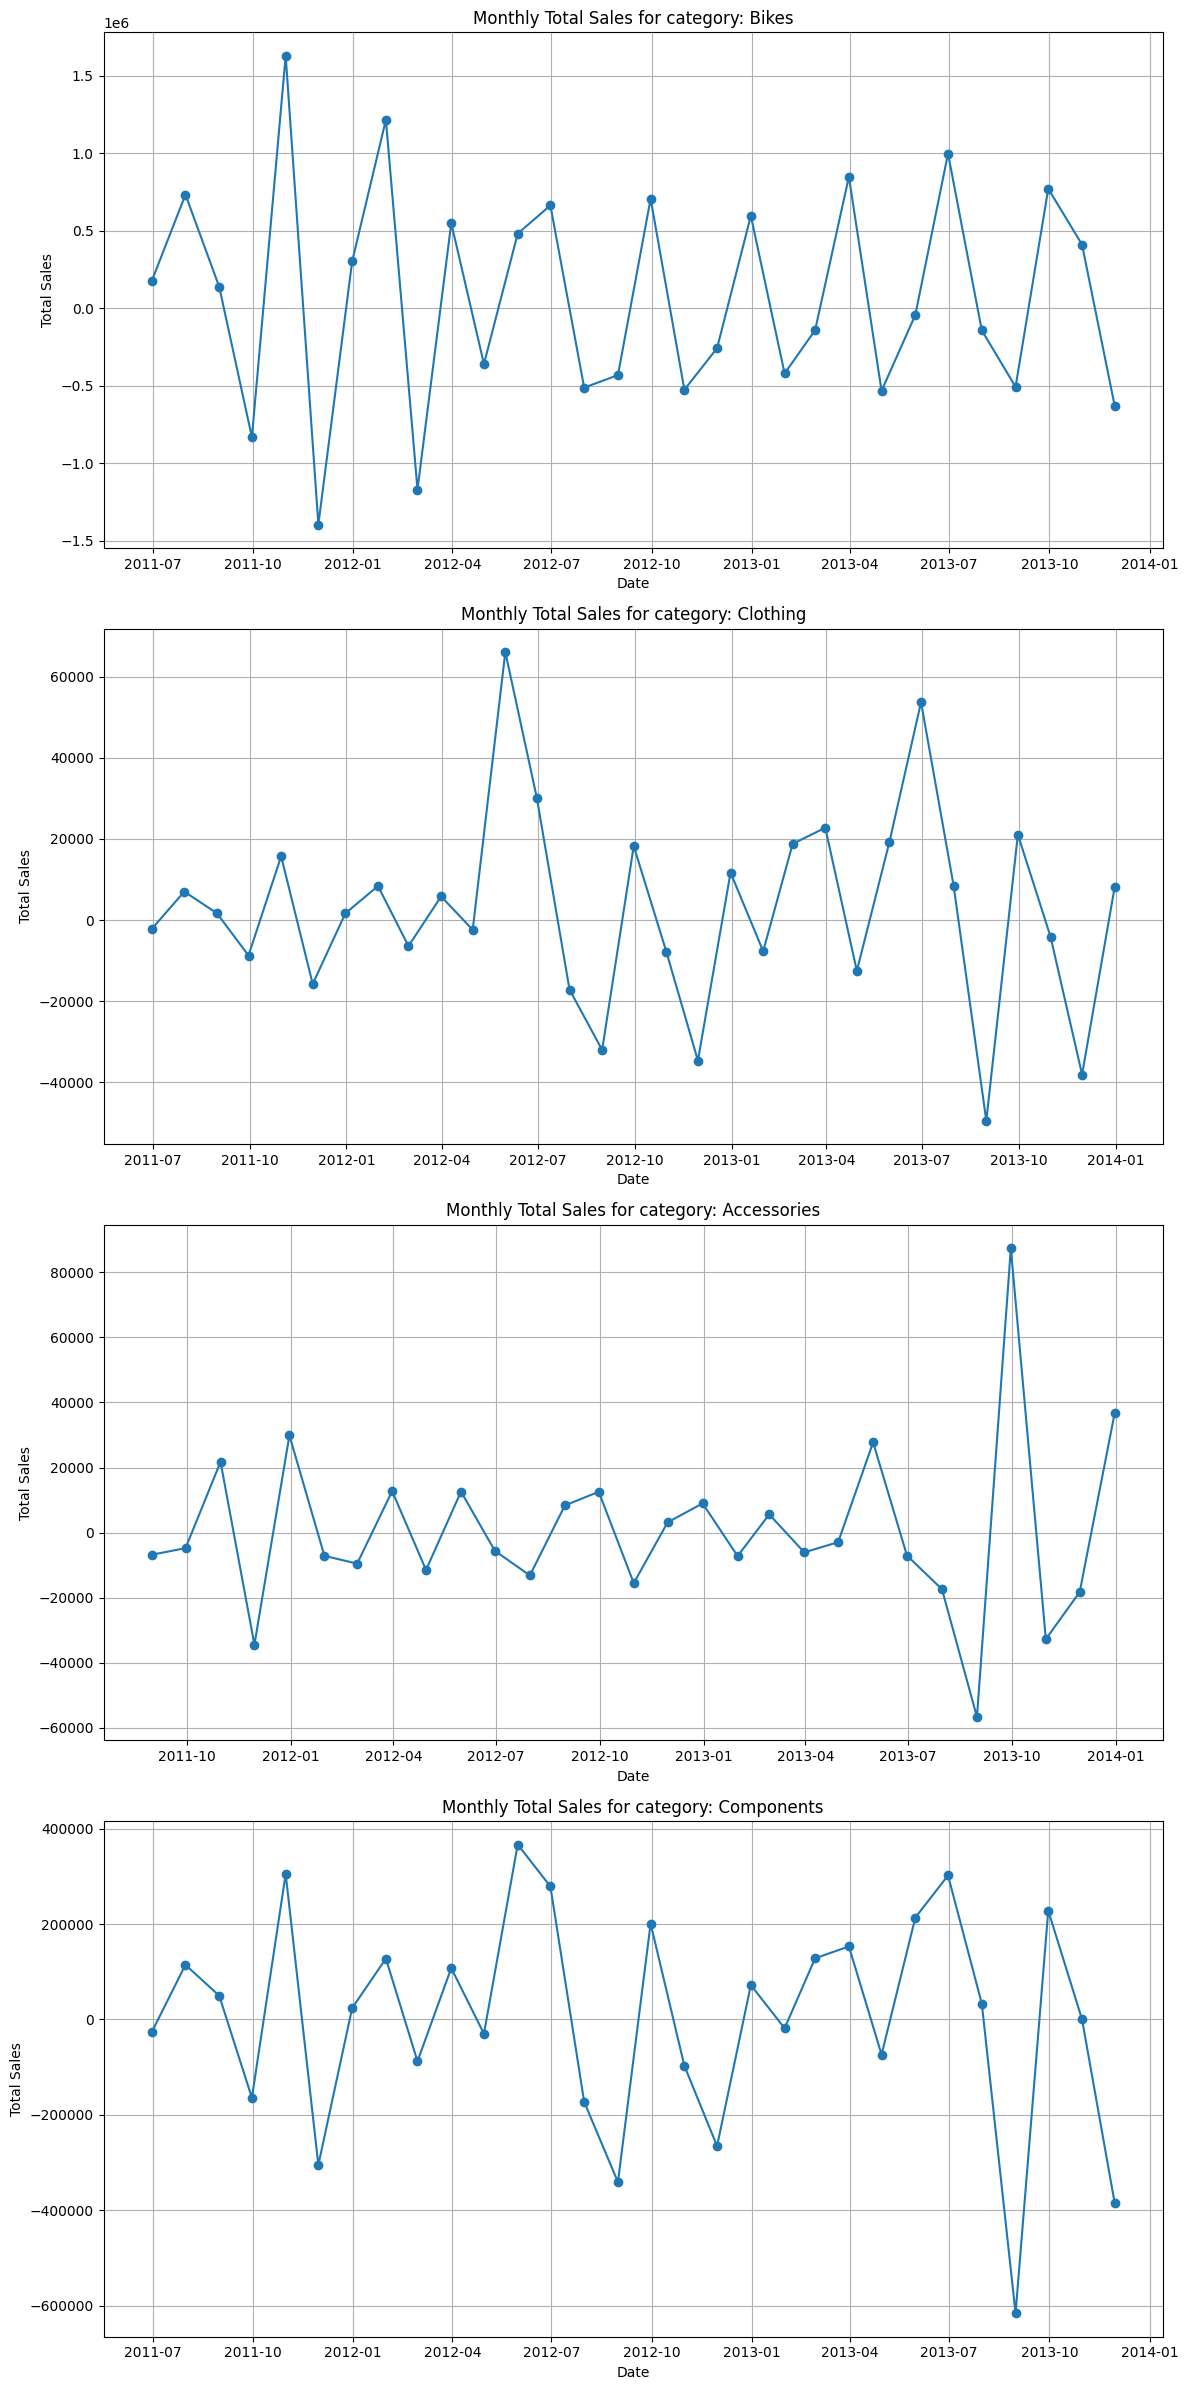

In [60]:
n_categories = len(categories)  # Total number of categories

plt.figure(figsize=(12, 6 * n_categories))  # Adjust figure size dynamically based on the number of categories

for i, (category, monthly_sales) in enumerate(stationary_train_data.items(), 1):
    plt.subplot(n_categories, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for category: {category}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## ARIMA

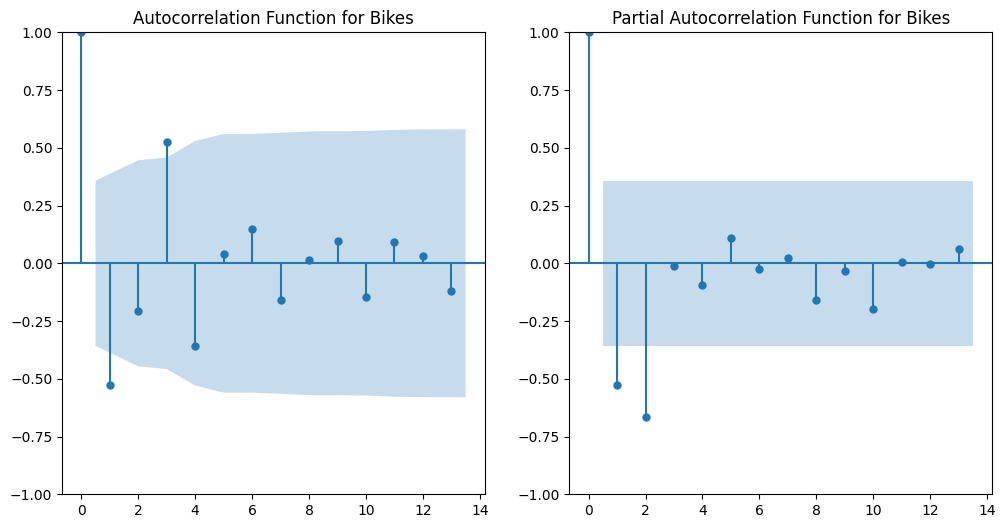

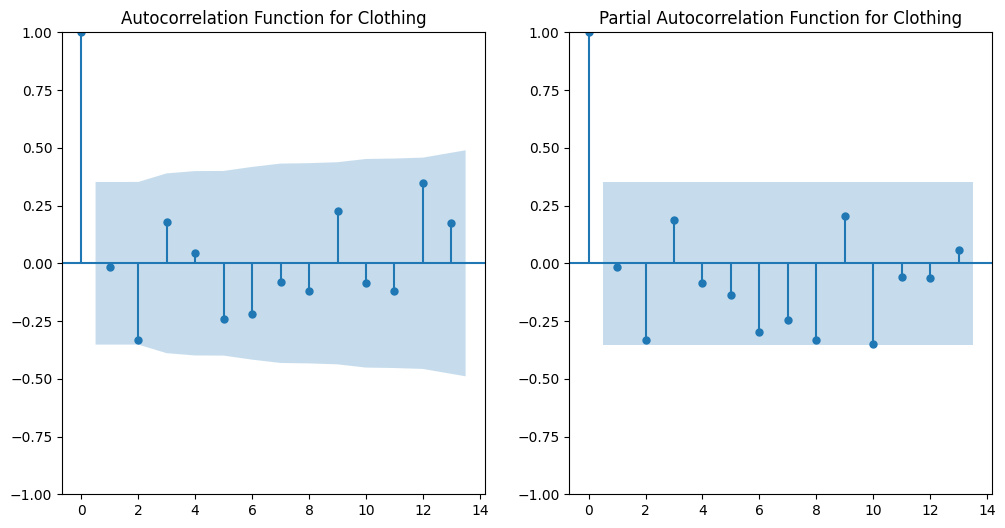

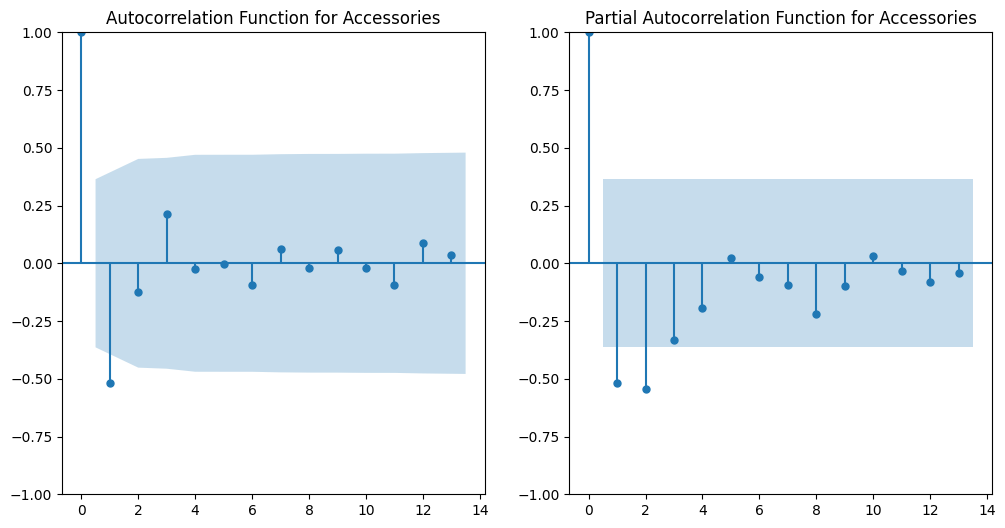

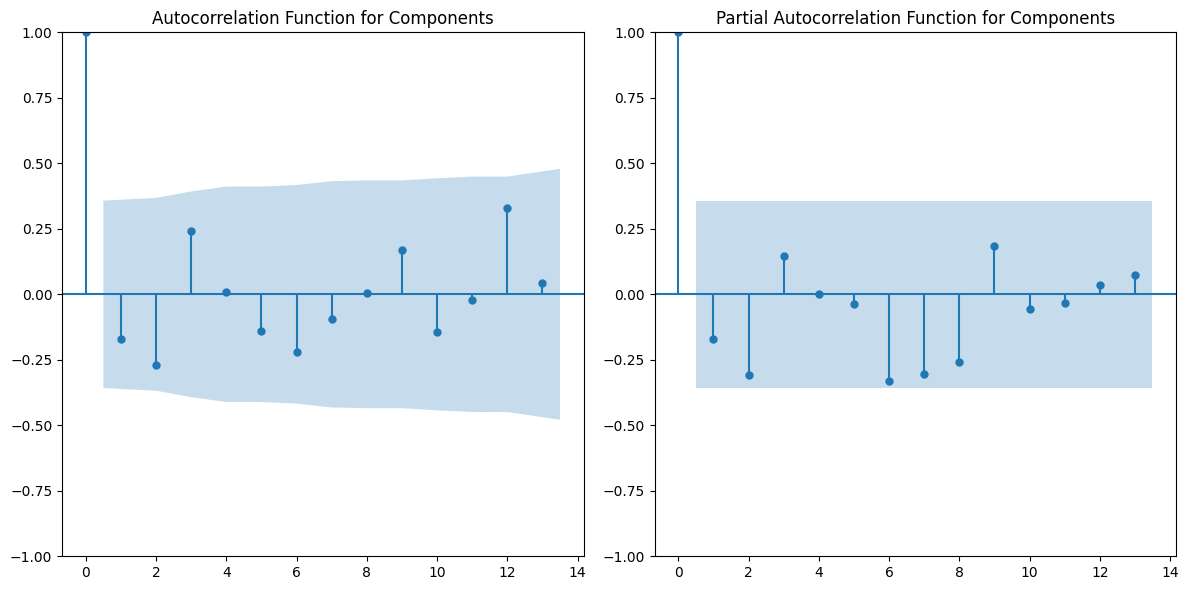

In [61]:
# Define maximum lags (adjust as necessary)
max_lags = 13

# Loop through each category and plot ACF and PACF
for category, monthly_sales in stationary_train_data.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {category}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {category}')
    
plt.tight_layout()
plt.show()

In [62]:
# model_categories = {}

# model_categories[categories[0]] = ARIMA(train_data[categories[0]], order=(2, 0, 3))
# model_categories[categories[1]] = ARIMA(train_data[categories[1]], order=(10, 0, 1))
# model_categories[categories[2]] = ARIMA(train_data[categories[2]], order=(2, 0, 1))
# model_categories[categories[3]] = ARIMA(train_data[categories[3]], order=(1, 0, 1))

model_categories = {}

model_categories[categories[0]] = ARIMA(train_data[categories[0]], order=(10, 0, 10))
model_categories[categories[1]] = ARIMA(train_data[categories[1]], order=(10, 0, 10))
model_categories[categories[2]] = ARIMA(train_data[categories[2]], order=(10, 0, 10))
model_categories[categories[3]] = ARIMA(train_data[categories[3]], order=(10, 0, 10))

In [63]:
model_fit_categories = {}

for (category, model) in model_categories.items():
    print(category)
    model_fit_categories[category] = model_categories[category].fit()

Bikes


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Clothing


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Accessories


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Components


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


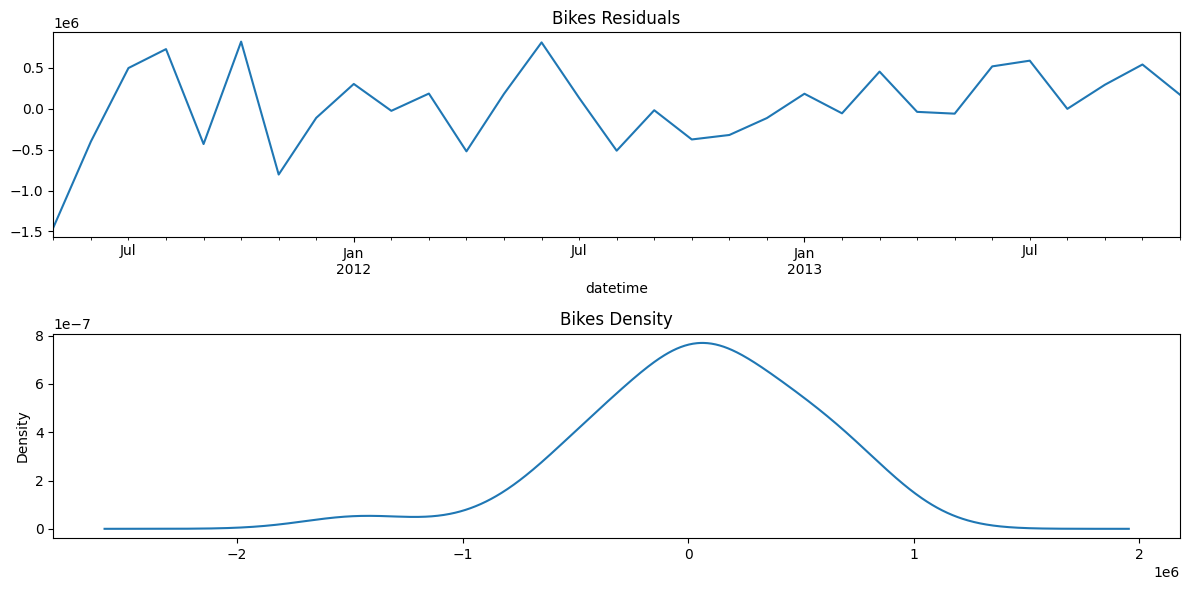

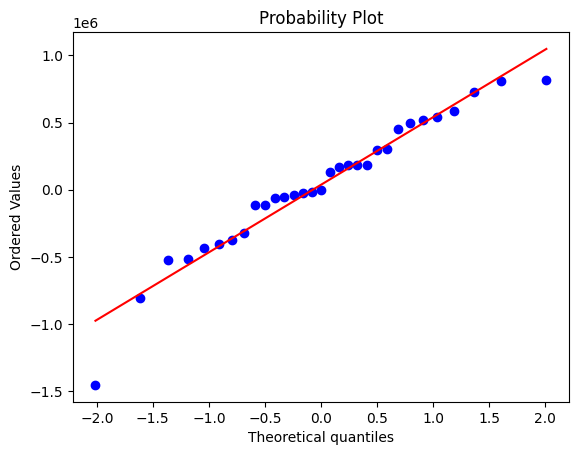

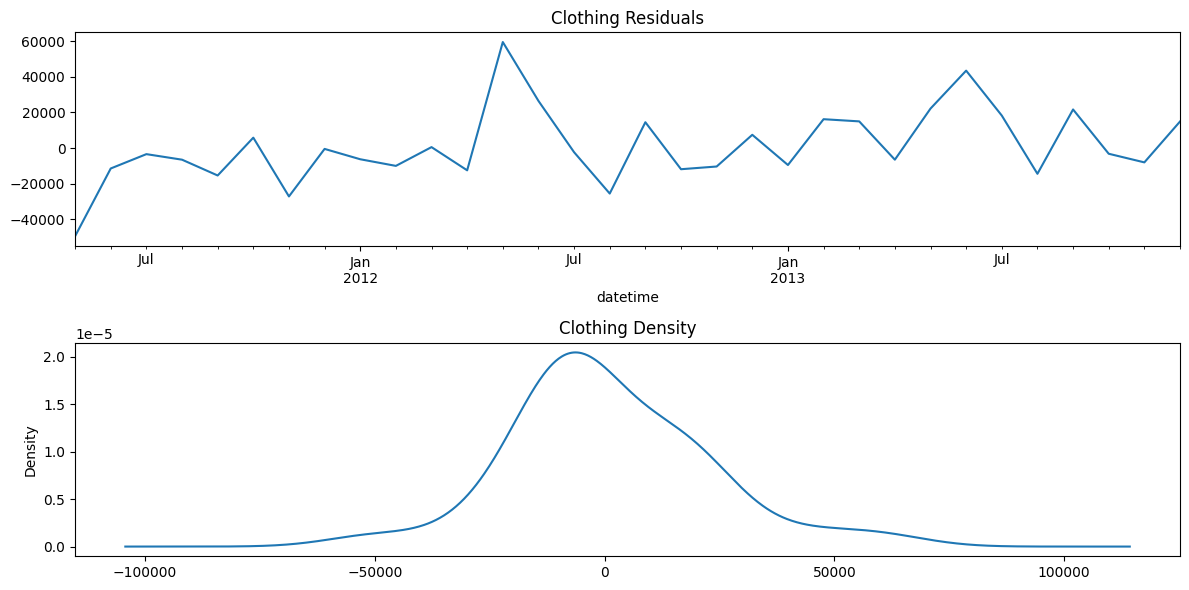

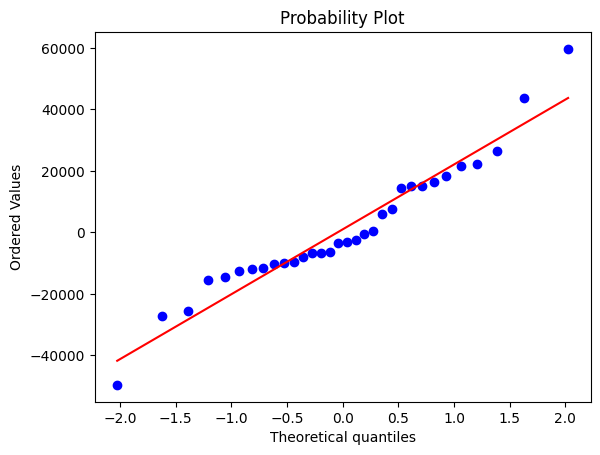

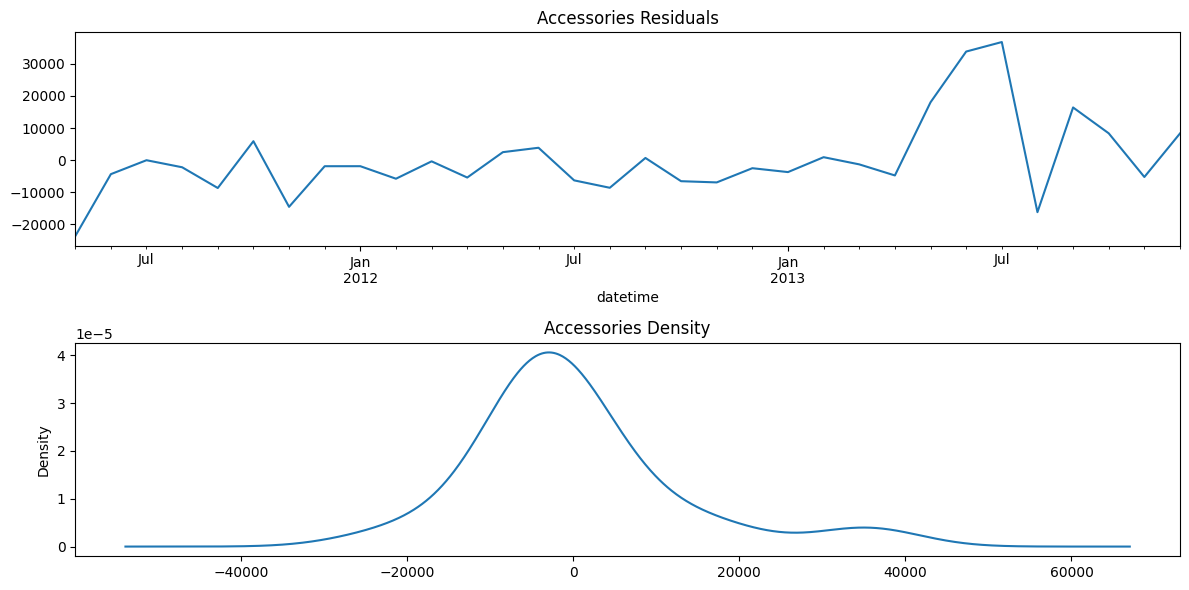

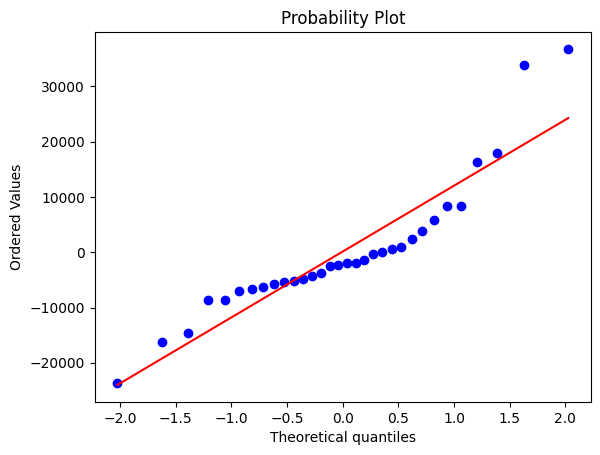

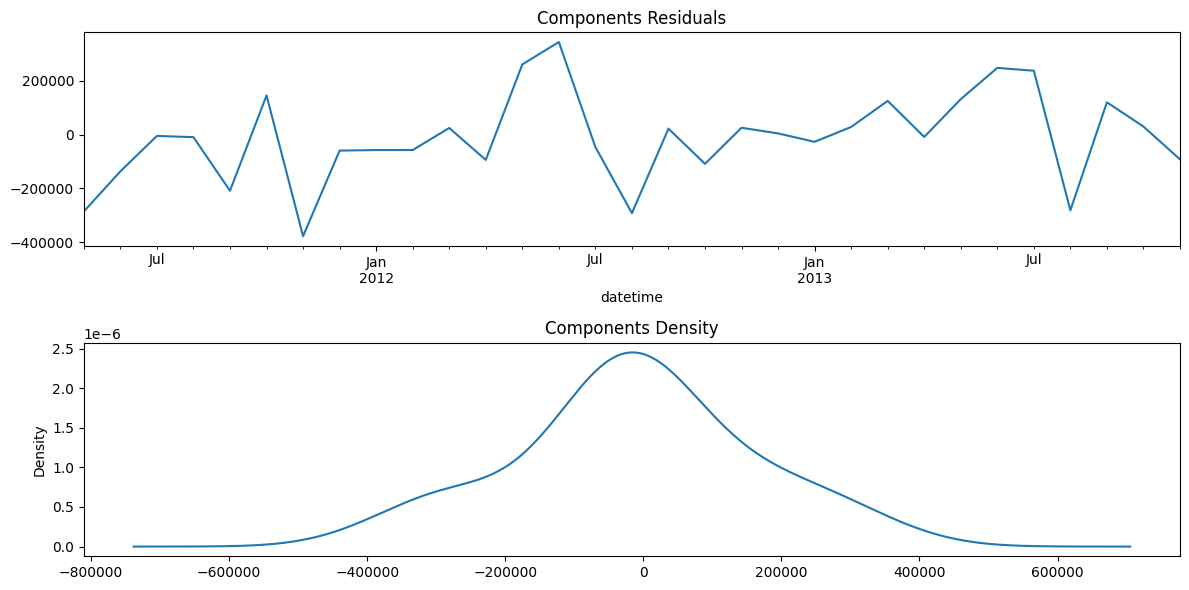

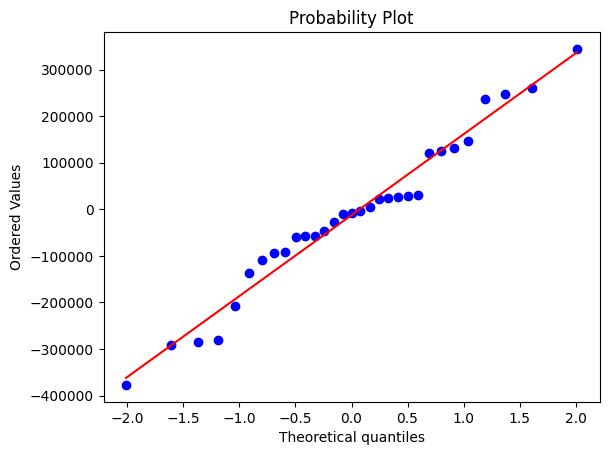

In [64]:
for (category, model) in model_fit_categories.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=category + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=category + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


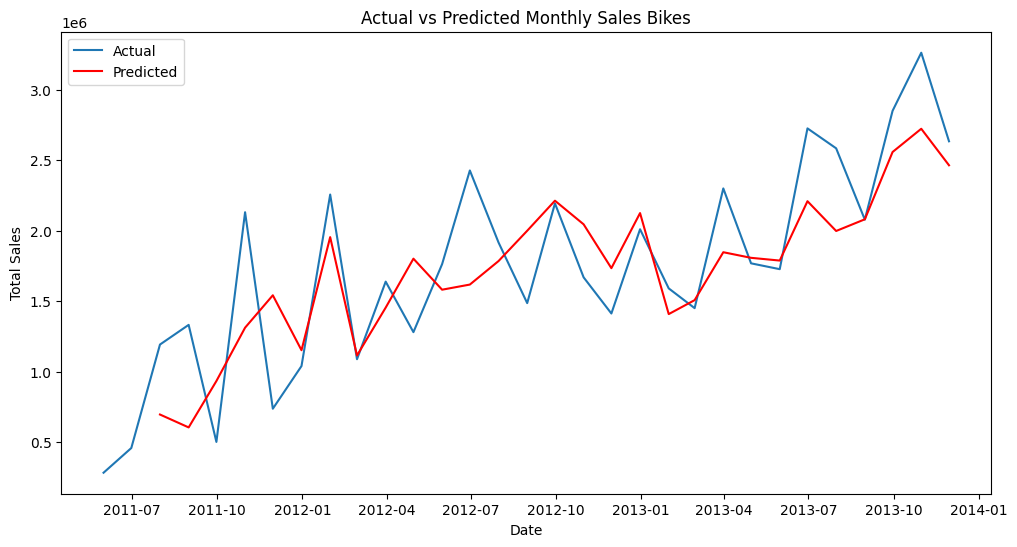

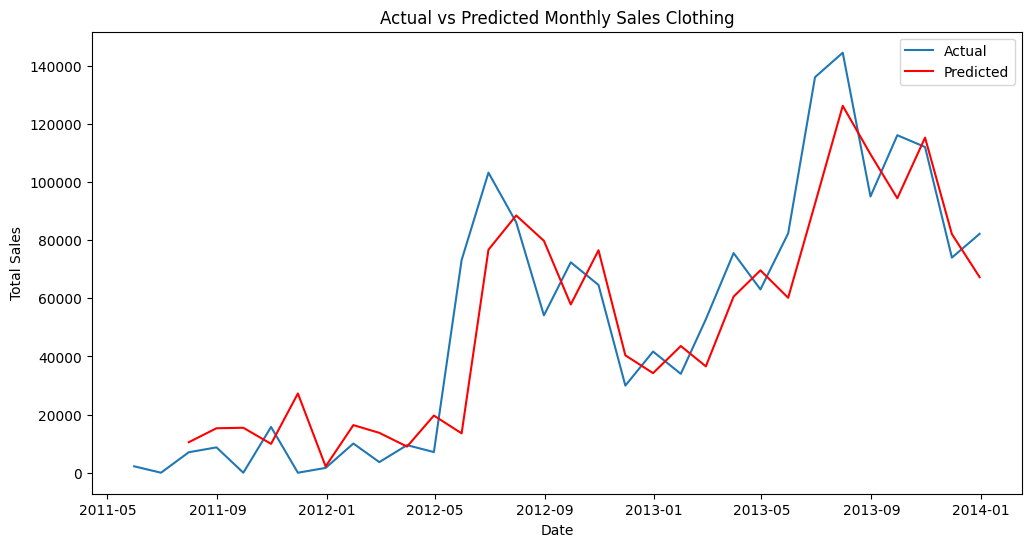

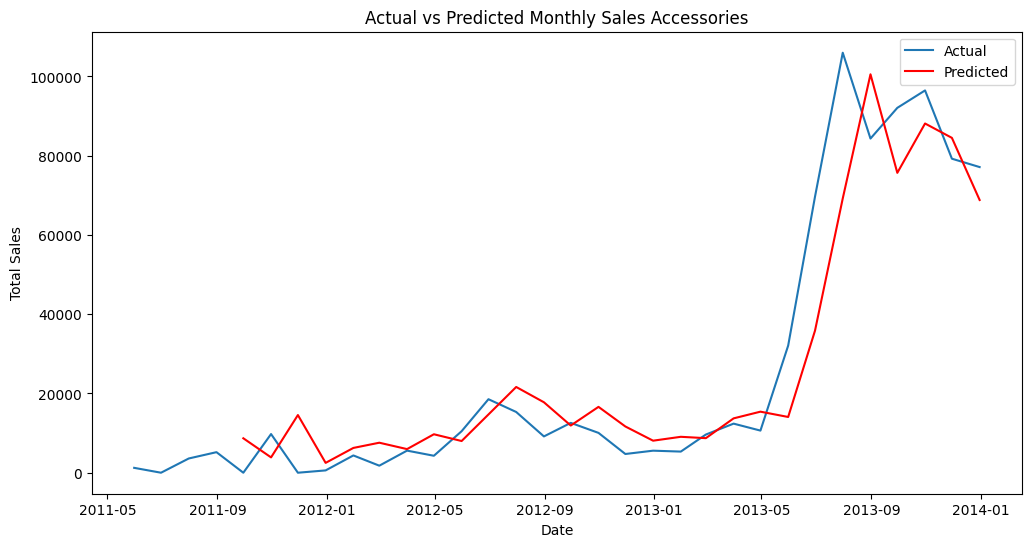

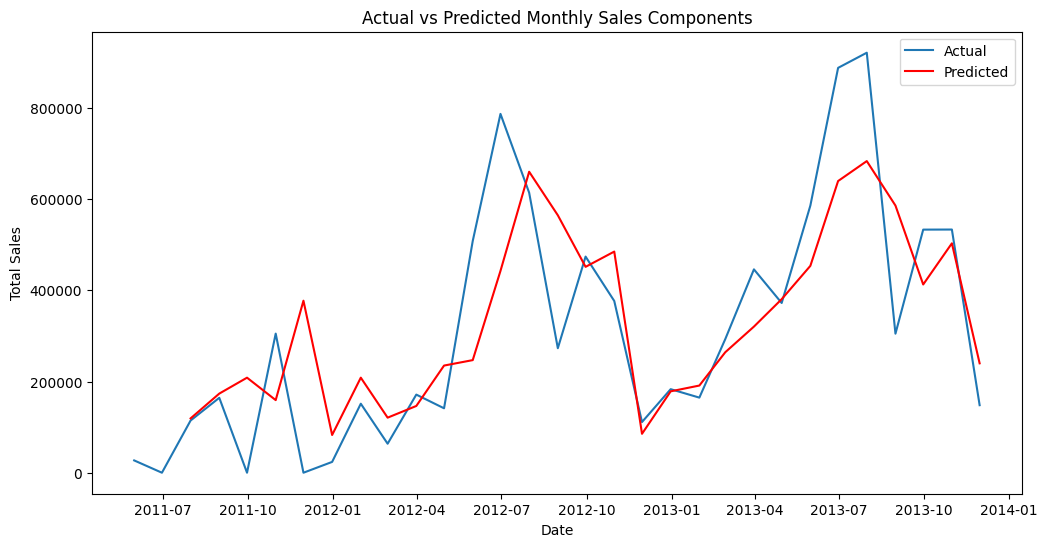

In [65]:
for (category, model) in model_fit_categories.items():
    # In-sample prediction
    predictions = model.predict(start=stationary_train_data[category].index[1], end=stationary_train_data[category].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[category], label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + category)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\973356165.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


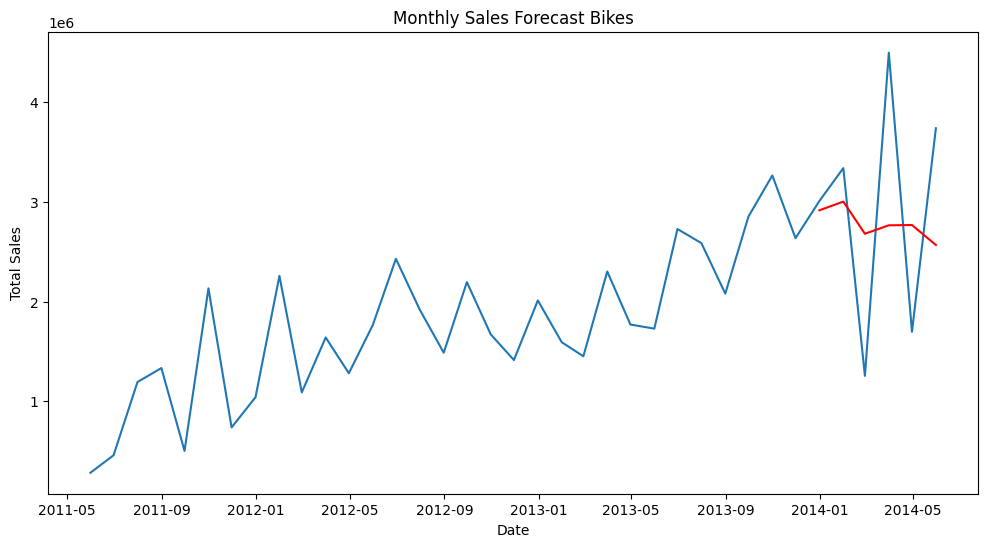

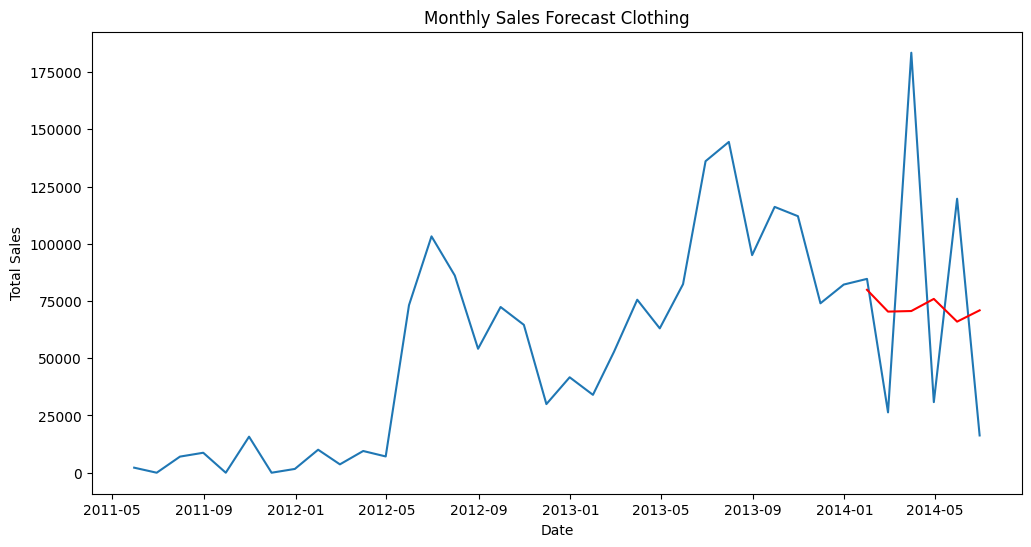

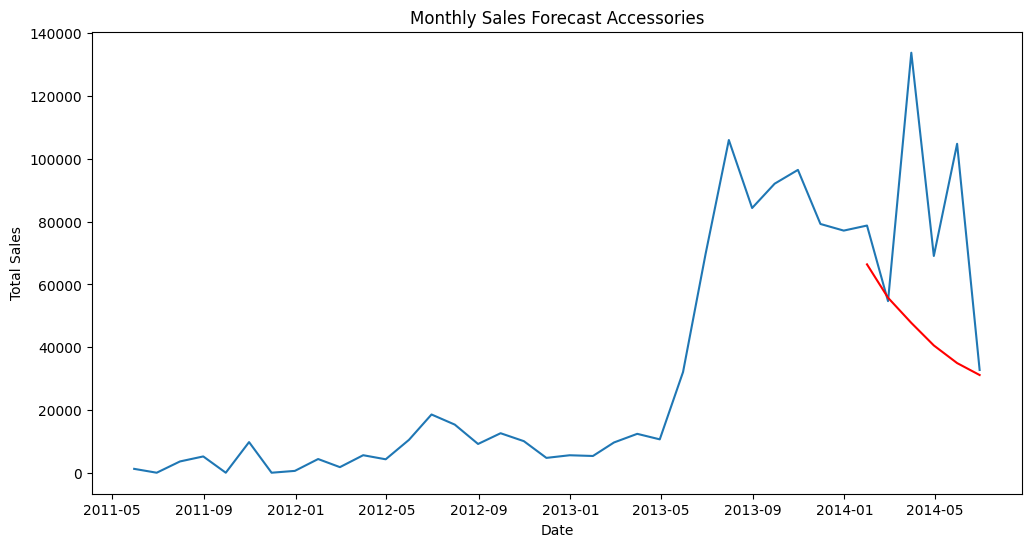

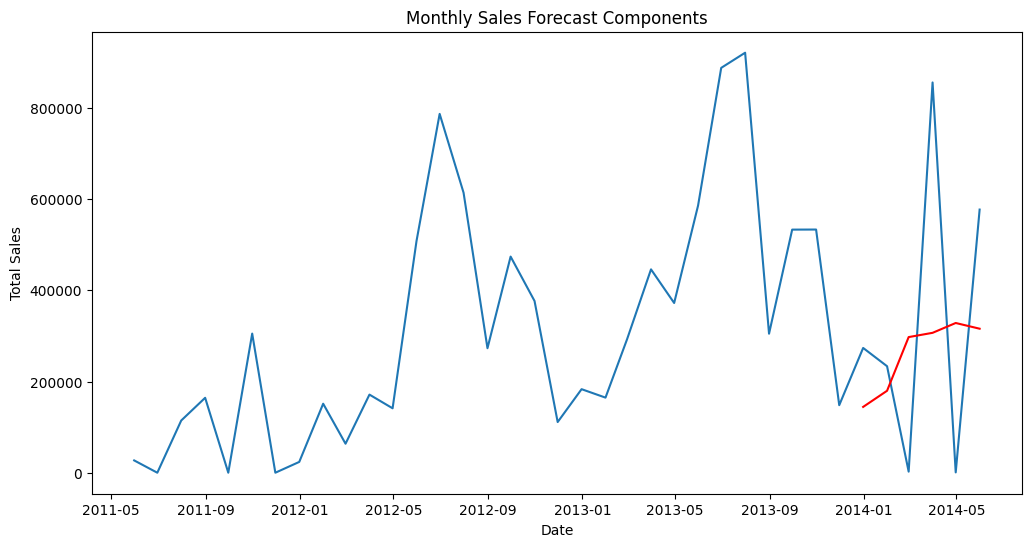

In [66]:
for (category, model) in model_fit_categories.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)


    # Create future dates
    last_date = train_data[category].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[category], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + category)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')


## Machine Learning

In [67]:
def add_lag(data, lags=3):
    lagged_data = {}  # To store the lagged DataFrames

    for category, series in data.items():
        print(f"Processing category: {category}")
        
        # Convert Series to DataFrame
        df = series.to_frame(name='sales')  # 'sales' becomes the column name
        
        # Add lag features
        for lag in range(1, lags + 1):
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
        
        # Drop NaN rows caused by lagging
        df = df.dropna()

        # Save the processed DataFrame
        lagged_data[category] = df
        
        # Display first rows for validation
        print(type(lagged_data[category]))
        
    
    return lagged_data

In [68]:
lagged_combined_data = add_lag(combined_data, 3)

Processing category: Bikes
<class 'pandas.core.frame.DataFrame'>
Processing category: Clothing
<class 'pandas.core.frame.DataFrame'>
Processing category: Accessories
<class 'pandas.core.frame.DataFrame'>
Processing category: Components
<class 'pandas.core.frame.DataFrame'>


In [69]:
def split_data(lagged_combined_data):
    lagged_train_data = {}
    lagged_test_data = {}
    
    for category, data in lagged_combined_data.items():
        lagged_train_data[category], lagged_test_data[category] = data[:-6], data[-6:]
        print(type(data))
        
    return lagged_train_data, lagged_test_data

In [70]:
lagged_train_data, lagged_test_data = split_data(lagged_combined_data)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [71]:
lagged_train_data

{'Bikes':                    sales   sales_lag_1   sales_lag_2   sales_lag_3
 datetime                                                          
 2011-08-31  1.332676e+06  1.193085e+06  4.589108e+05  2.837037e+05
 2011-09-30  5.020738e+05  1.332676e+06  1.193085e+06  4.589108e+05
 2011-10-31  2.131871e+06  5.020738e+05  1.332676e+06  1.193085e+06
 2011-11-30  7.378398e+05  2.131871e+06  5.020738e+05  1.332676e+06
 2011-12-31  1.040555e+06  7.378398e+05  2.131871e+06  5.020738e+05
 2012-01-31  2.257282e+06  1.040555e+06  7.378398e+05  2.131871e+06
 2012-02-29  1.088960e+06  2.257282e+06  1.040555e+06  7.378398e+05
 2012-03-31  1.639494e+06  1.088960e+06  2.257282e+06  1.040555e+06
 2012-04-30  1.281013e+06  1.639494e+06  1.088960e+06  2.257282e+06
 2012-05-31  1.763563e+06  1.281013e+06  1.639494e+06  1.088960e+06
 2012-06-30  2.428146e+06  1.763563e+06  1.281013e+06  1.639494e+06
 2012-07-31  1.917286e+06  2.428146e+06  1.763563e+06  1.281013e+06
 2012-08-31  1.486989e+06  1.917286e+06

In [72]:
def train_stacking_model(data):
    trained_models = {}
    scalers_X = {}

    for category, df in data.items():
        print(f"Training Stacking model for {category}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features only
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # Initialize base models
        lr = LinearRegression()
        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Initialize stacking regressor
        stacking_model = StackingRegressor(
            estimators=[
                ('lr', lr),      # Linear Regression
                ('xgb', xgb)     # XGBoost
            ],
            final_estimator=LinearRegression()  # Meta-model
        )

        # Leave-One-Out Cross-Validation (LOOCV)
        loo = LeaveOneOut()
        y_preds = []
        y_actuals = []

        for train_index, test_index in loo.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train and predict with stacking model
            stacking_model.fit(X_train, y_train)
            y_pred = stacking_model.predict(X_test)

            y_preds.append(y_pred[0])
            y_actuals.append(y_test)

        # Compute LOOCV RMSE
        rmse = np.sqrt(mean_squared_error(y_actuals, y_preds))
        print(f"{category} - LOOCV RMSE: {rmse:.2f}")

        # Train on full data
        stacking_model.fit(X_scaled, y)

        # Save model and scaler
        trained_models[category] = stacking_model
        scalers_X[category] = scaler_X

    return trained_models, scalers_X

In [73]:
train_models, scalers_X = train_stacking_model(lagged_train_data)

Training Stacking model for Bikes...
Bikes - LOOCV RMSE: 576600.34
Training Stacking model for Clothing...
Clothing - LOOCV RMSE: 26298.25
Training Stacking model for Accessories...
Accessories - LOOCV RMSE: 16951.25
Training Stacking model for Components...
Components - LOOCV RMSE: 260064.40


In [74]:
train_models

{'Bikes': StackingRegressor(estimators=[('lr', LinearRegression()),
                               ('xgb',
                                XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             lear

In [75]:
def test_simple_model(trained_models, scalers_X, test_data):
    categories_predict = {}
    
    for category, df in test_data.items():
        print(f"Testing model for {category}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features using the saved scaler
        X_scaled = scalers_X[category].transform(X)

        # Predict
        y_pred = trained_models[category].predict(X_scaled)
        y_pred = pd.Series(y_pred, index=df.index)

        # Calculate MSE and RMSE
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Print evaluation metrics
        print(f"{category} - Mean Squared Error (MSE): {mse:.2f}")
        print(f"{category} - Root Mean Squared Error (RMSE): {rmse:.2f}\n")
        
        categories_predict[category] = y_pred
        
    return categories_predict

In [76]:
categories_predict = test_simple_model(train_models, scalers_X, lagged_test_data)

Testing model for Bikes...
Bikes - Mean Squared Error (MSE): 1510548036209.21
Bikes - Root Mean Squared Error (RMSE): 1229043.55

Testing model for Clothing...
Clothing - Mean Squared Error (MSE): 13865420856.58
Clothing - Root Mean Squared Error (RMSE): 117751.52

Testing model for Accessories...
Accessories - Mean Squared Error (MSE): 4382964869.64
Accessories - Root Mean Squared Error (RMSE): 66203.96

Testing model for Components...
Components - Mean Squared Error (MSE): 179324294805.11
Components - Root Mean Squared Error (RMSE): 423466.99



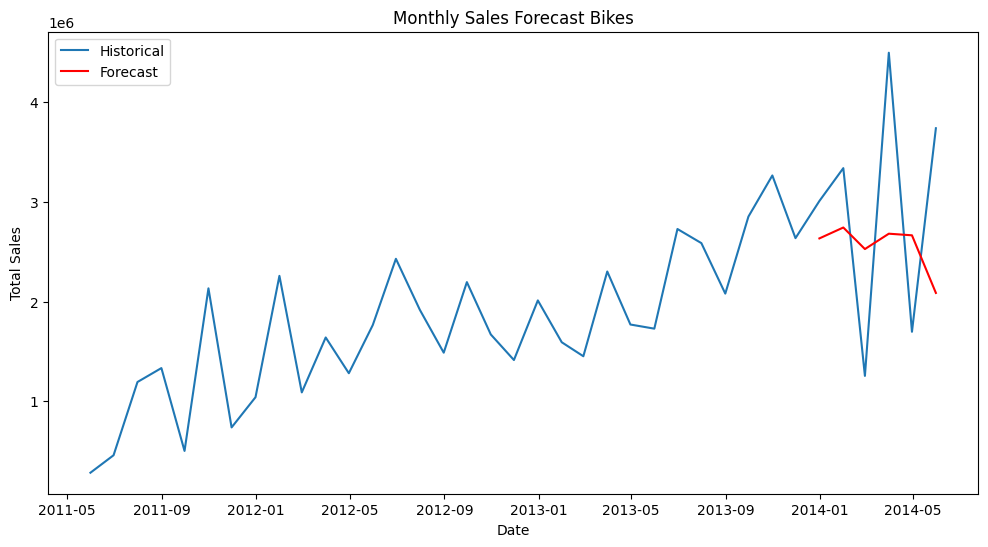

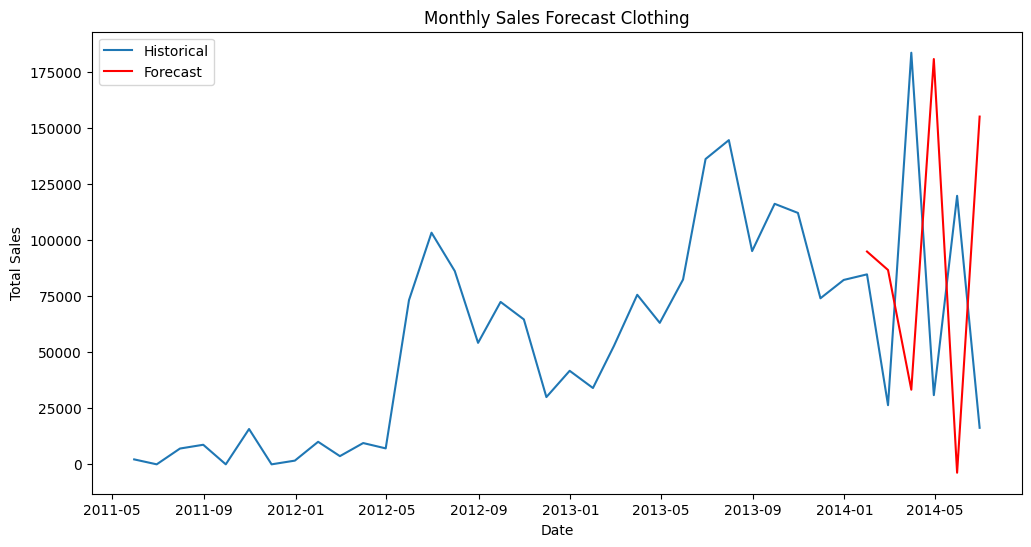

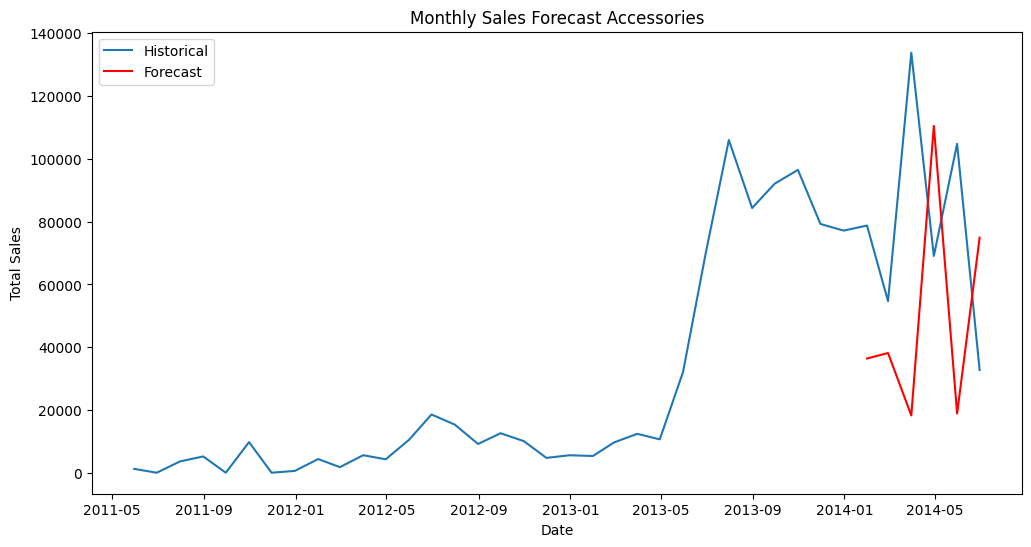

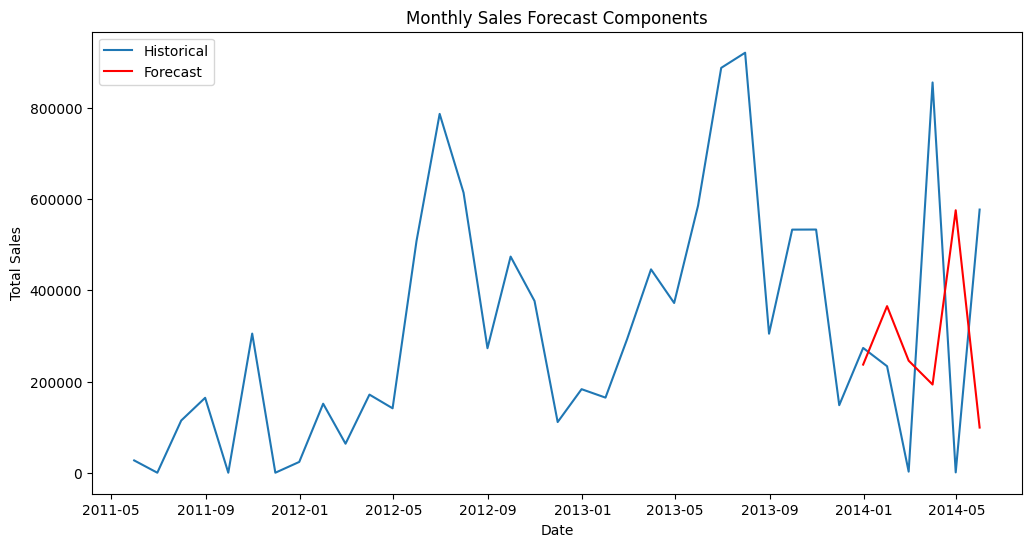

In [77]:
for (category, model) in model_fit_categories.items():

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[category], label='Historical')
    plt.plot(categories_predict[category], label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + category)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

In [78]:
def forecast_next_months(trained_models, scalers_X, data, months=6):
    future_forecasts = {}

    for category, model in trained_models.items():
        print(f"Forecasting for {category}...")

        # Get the last row of the dataset for lagged features
        last_row = data[category].iloc[-1]
        lag_1, lag_2, lag_3 = last_row['sales_lag_1'], last_row['sales_lag_2'], last_row['sales_lag_3']

        # Start forecasting from the last date in the dataset
        last_date = data[category].index[-1]

        # Generate future dates
        future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

        # List to store forecasts
        forecasts = []

        for date in future_dates:
            # Create features for the current prediction
            X_new = pd.DataFrame([[lag_1, lag_2, lag_3]], columns=['sales_lag_1', 'sales_lag_2', 'sales_lag_3'])

            # Scale features
            scaler_X = scalers_X[category]
            X_new_scaled = scaler_X.transform(X_new)

            # Predict the next month's sales
            next_sales = model.predict(X_new_scaled)[0]

            # Append prediction to the forecasts
            forecasts.append(next_sales)

            # Update lagged features
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = next_sales

        # Convert forecasts to pandas Series with dates as the index
        future_forecasts[category] = pd.Series(data=forecasts, index=future_dates, name='forecast')

    return future_forecasts


In [79]:
future_forecasts = forecast_next_months(train_models, scalers_X, lagged_test_data, 6)
future_forecasts

Forecasting for Bikes...
Forecasting for Clothing...
Forecasting for Accessories...
Forecasting for Components...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3504833425.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3504833425.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3504833425.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3504833425.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='

{'Bikes': 2014-06-30    2.085872e+06
 2014-07-31    3.143925e+06
 2014-08-31    2.025274e+06
 2014-09-30    2.296625e+06
 2014-10-31    2.608303e+06
 2014-11-30    2.183423e+06
 Freq: ME, Name: forecast, dtype: float64,
 'Clothing': 2014-07-31    154980.291996
 2014-08-31    112377.738286
 2014-09-30     95494.260721
 2014-10-31    100736.849603
 2014-11-30    101565.291182
 2014-12-31     96097.632703
 Freq: ME, Name: forecast, dtype: float64,
 'Accessories': 2014-07-31    74885.129936
 2014-08-31    30005.489991
 2014-09-30    22428.469219
 2014-10-31    24806.642093
 2014-11-30    27806.731597
 2014-12-31    30354.807909
 Freq: ME, Name: forecast, dtype: float64,
 'Components': 2014-06-30     99031.284302
 2014-07-31    395367.035348
 2014-08-31    388246.336941
 2014-09-30    348632.851647
 2014-10-31    305029.038151
 2014-11-30    276705.773021
 Freq: ME, Name: forecast, dtype: float64}

C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3386829874.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


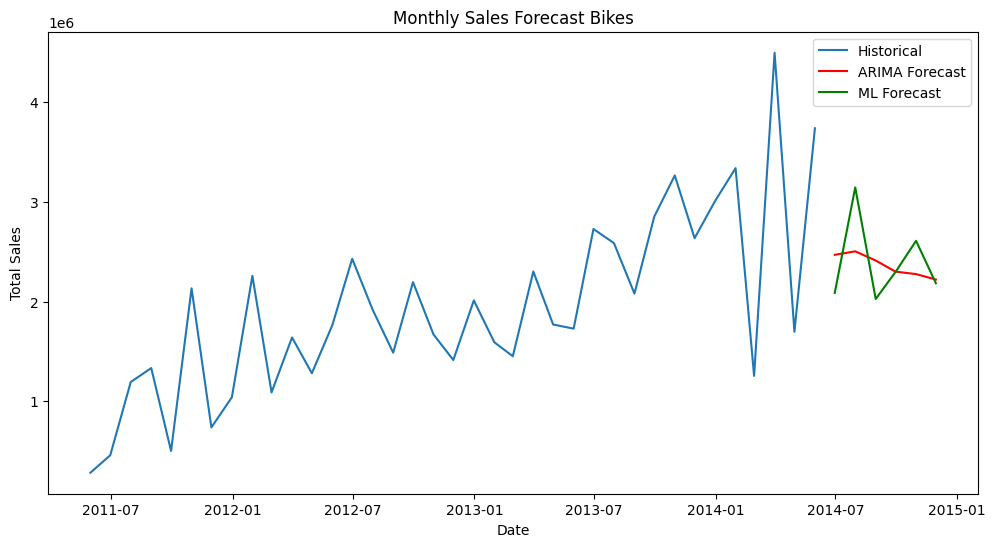

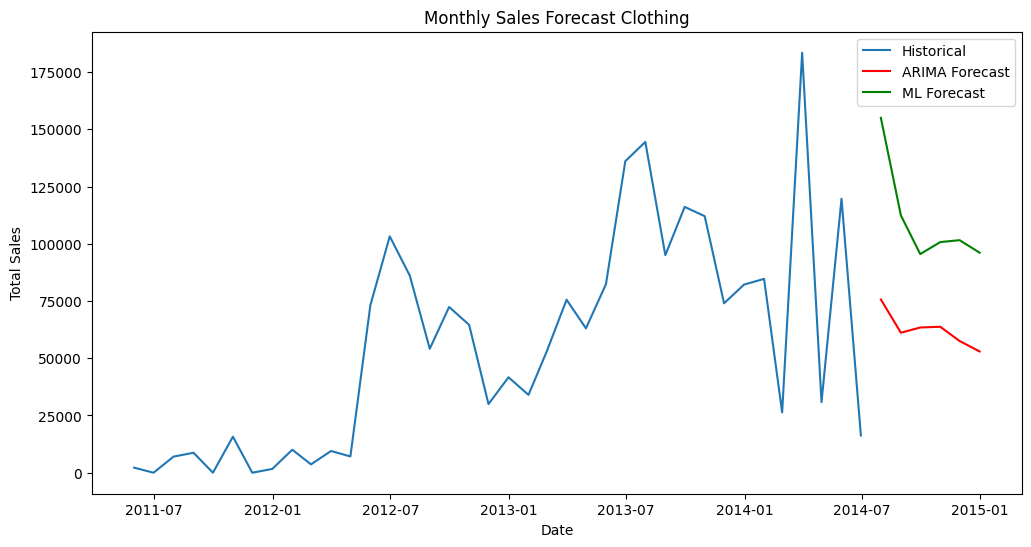

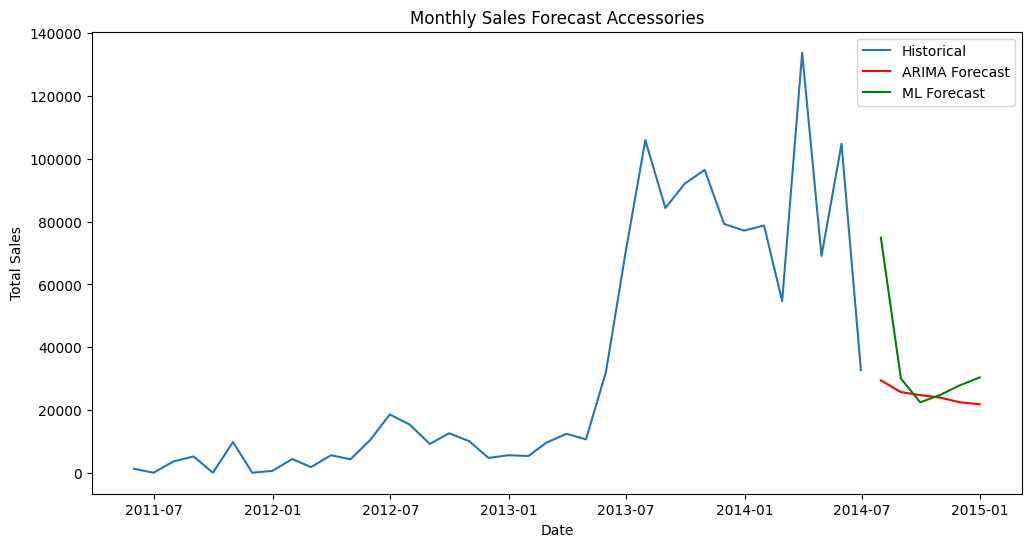

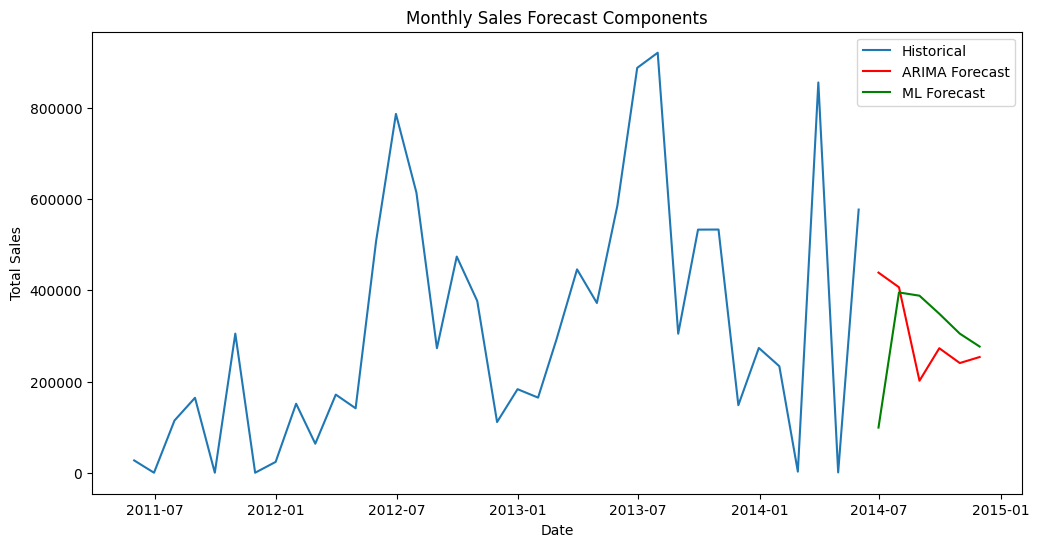

In [80]:
for (category, model) in model_fit_categories.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[category].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[category], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[category], label='ML Forecast', color='green')
    plt.title('Monthly Sales Forecast ' + category)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


## LSTM

In [81]:
def train_test_split_category_lstm(sales_data_category):
    combine_train_test = {
        category: data['LineTotal'].resample('ME').sum() for category, data in sales_data_category.items()
    }
    
    
    train_monthly_sales_by_category = {
        category: data['LineTotal'].resample('ME').sum()[:-6] for category, data in sales_data_category.items()
    }
    
    test_monthly_sales_by_category = {
        category: data['LineTotal'].resample('ME').sum()[-9:] for category, data in sales_data_category.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_category, test_monthly_sales_by_category)

In [82]:
# Resample 'LineTotal' for each category in the dictionary
combined_data, train_data, test_data = train_test_split_category_lstm(sales_data_category)

In [83]:
test_data

{'Bikes': datetime
 2013-09-30    2.851292e+06
 2013-10-31    3.263534e+06
 2013-11-30    2.635099e+06
 2013-12-31    3.007522e+06
 2014-01-31    3.336977e+06
 2014-02-28    1.254322e+06
 2014-03-31    4.493871e+06
 2014-04-30    1.696566e+06
 2014-05-31    3.736849e+06
 Freq: ME, Name: LineTotal, dtype: float64,
 'Clothing': datetime
 2013-10-31    112044.2611
 2013-11-30     73999.0991
 2013-12-31     82177.8684
 2014-01-31     84661.5176
 2014-02-28     26356.5240
 2014-03-31    183438.3092
 2014-04-30     30832.3390
 2014-05-31    119667.8355
 2014-06-30     16277.1200
 Freq: ME, Name: LineTotal, dtype: float64,
 'Accessories': datetime
 2013-10-31     96479.7704
 2013-11-30     79248.9620
 2013-12-31     77136.9113
 2014-01-31     78746.9906
 2014-02-28     54655.9080
 2014-03-31    133808.4583
 2014-04-30     69061.5480
 2014-05-31    104786.0150
 2014-06-30     32728.7200
 Freq: ME, Name: LineTotal, dtype: float64,
 'Components': datetime
 2013-09-30    533164.1401
 2013-10-31  

In [84]:
def train_lstm_with_generator(data, look_back=3, batch_size=4, epochs=50):
    trained_models = {}
    scalers = {}

    for category, df in data.items():
        print(f"Training LSTM model for {category}...")

        # Scale sales data
        df = pd.Series.to_frame(df)
        scaler = MinMaxScaler(feature_range=(0, 1))
        sales_scaled = scaler.fit_transform(df)

        # Use TimeseriesGenerator to create input-output pairs
        generator = TimeseriesGenerator(sales_scaled, sales_scaled, length=look_back, batch_size=batch_size)

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))  # Input shape: (look_back, n_features=1)
        model.add(Dense(1))  # Predict the next step
        model.compile(optimizer='adam', loss='mse')

        # Train the model using generator
        model.fit(generator, epochs=epochs, verbose=1)

        # Save the model and scaler
        trained_models[category] = model
        scalers[category] = scaler

        print(f"{category} - Training completed.")

    return trained_models, scalers

In [85]:
lstm_models, lstm_scalers = train_lstm_with_generator(train_data, look_back=3)

Training LSTM model for Bikes...
Epoch 1/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3480
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3128 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2398 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1641 
Epoch 5/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0743

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1313 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1107 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0667 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0831 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0314 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0279 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0263 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0346 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0284 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3581
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2374 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2473 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1934 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2387 
Epoch 6/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1665 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1528 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0645 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0526 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0299 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0458 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0462 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0541 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0343     
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0569 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0500 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0568 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0366 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2111
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2018 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1848 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1013 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1447 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2853

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1266 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0690 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0598 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0811 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0495 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1272 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0496 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0412 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0427 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0302 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0400 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0337 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0227     
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3393
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2618 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1672 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2427 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1600 
Epoch 6/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0490

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0764 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0675 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0752 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1215 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0552 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0846 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0635 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0595 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0629 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0742 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0580 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0415 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0429 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [86]:
def test_lstm_model(trained_models, scalers, test_data, look_back=3):
    predictions = {}

    for category, df in test_data.items():
        print(f"Testing LSTM model for {category}...")
        
        # Save the original index to align predictions later
        original_index = df.index

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[category]
        scaled_data = scaler.transform(df)

        # Ensure look_back does not exceed the available data length
        if len(scaled_data) <= look_back:
            print(f"Not enough data for {category}: reducing look_back to {len(scaled_data) - 1}")
            look_back = len(scaled_data) - 1

        # Prepare input sequences using TimeseriesGenerator
        generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)

        # Get the trained model
        model = trained_models[category]

        # Make predictions
        y_pred_scaled = []
        for i in range(len(generator)):
            X, _ = generator[i]  # Get input sequence
            y_pred = model.predict(X, verbose=0)  # Predict next step
            y_pred_scaled.append(y_pred[0][0])  # Append prediction

        # Inverse transform predictions back to original scale
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).ravel()

        # Align predictions with the correct index
        prediction_index = original_index[-len(y_pred):]
        predictions[category] = pd.Series(y_pred, index=prediction_index)

        print(f"{category} - Testing completed.")

    return predictions


In [87]:
lstm_res = test_lstm_model(lstm_models, lstm_scalers, test_data)

Testing LSTM model for Bikes...
Bikes - Testing completed.
Testing LSTM model for Clothing...
Clothing - Testing completed.
Testing LSTM model for Accessories...
Accessories - Testing completed.
Testing LSTM model for Components...
Components - Testing completed.


In [88]:
def forecast_lstm_model(trained_models, scalers, test_data, look_back=3, forecast_steps=6):
    forecasts = {}

    for category, df in test_data.items():
        print(f"Forecasting next {forecast_steps} months for {category}...")

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[category]
        scaled_data = scaler.transform(df)

        # Start with the last look_back window of scaled data
        last_window = scaled_data[-look_back:].reshape(1, look_back, 1)

        # Initialize list to store predictions
        forecast_scaled = []

        # Get the trained model
        model = trained_models[category]

        # Iteratively predict the next steps
        for step in range(forecast_steps):
            # Predict next value
            next_pred = model.predict(last_window, verbose=0)[0][0]
            forecast_scaled.append(next_pred)

            # Update the input window: remove oldest value, append predicted value
            last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

        # Inverse transform predictions back to original scale
        forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).ravel()

        # Create a date range for the forecast period
        start_date = df.index[-1]  # Last date in the test data
        forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

        # Store forecast as a Pandas Series
        forecasts[category] = pd.Series(forecast, index=forecast_index)

        print(f"{category} - Forecasting completed.")

    return forecasts


In [89]:
forecast_lstms = forecast_lstm_model(lstm_models, lstm_scalers, test_data)

Forecasting next 6 months for Bikes...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3010390994.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Bikes - Forecasting completed.
Forecasting next 6 months for Clothing...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3010390994.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Clothing - Forecasting completed.
Forecasting next 6 months for Accessories...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3010390994.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Accessories - Forecasting completed.
Forecasting next 6 months for Components...
Components - Forecasting completed.


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3010390994.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


In [109]:
lstm_res

{'Bikes': datetime
 2013-12-31    3061455.50
 2014-01-31    3141991.00
 2014-02-28    3001849.25
 2014-03-31    2883733.00
 2014-04-30    2976325.50
 2014-05-31    2466571.00
 Freq: ME, dtype: float32,
 'Clothing': datetime
 2014-01-31    83162.828125
 2014-02-28    79513.617188
 2014-03-31    63130.851562
 2014-04-30    89349.593750
 2014-05-31    68979.703125
 2014-06-30    94511.781250
 Freq: ME, dtype: float32,
 'Accessories': datetime
 2014-01-31    80600.359375
 2014-02-28    76125.273438
 2014-03-31    67206.804688
 2014-04-30    84488.148438
 2014-05-31    79366.804688
 2014-06-30    98250.781250
 Freq: ME, dtype: float32,
 'Components': datetime
 2013-12-31    378099.375000
 2014-01-31    331643.187500
 2014-02-28    296074.187500
 2014-03-31    261371.671875
 2014-04-30    361595.906250
 2014-05-31    299743.218750
 Freq: ME, dtype: float32}

In [112]:
# Initialize a dictionary to store MSE for each forecast method
rmse_results = {}

# Directory to save figures
output_dir = "results\\categories\\test"
os.makedirs(output_dir, exist_ok=True)

rows, cols = 2, 2  # 2x2 grid for 4 categories

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (category, model) in enumerate(model_fit_categories.items()):
    ax = axes[i]
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[category].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]
    
    # Actual data (test data for evaluation)
    actual = combined_data[category][-len(forecast_series):]  # Align test period with forecast

    # Forecasts
    arima_forecast = forecast_series
    ml_forecast = categories_predict[category]
    lstm_forecast = lstm_res[category]

    # Calculate MSE for each method
    rmse_arima = root_mean_squared_error(actual, arima_forecast)
    rmse_ml = root_mean_squared_error(actual, ml_forecast)
    rmse_lstm = root_mean_squared_error(actual, lstm_forecast)

    # Store MSE in dictionary
    rmse_results[category] = {
        'ARIMA': rmse_arima,
        'ML': rmse_ml,
        'LSTM': rmse_lstm
    }
    
    # Plot the forecast
    #plt.figure(figsize=(12, 6))
    ax.plot(combined_data[category], label='Historical')
    ax.plot(forecast_series, label='ARIMA Forecast', color='red')
    ax.plot(categories_predict[category], label='ML Forecast', color='green')
    ax.plot(lstm_res[category], label='LSTM Forecast', color='black')

    # Add MSE as text box (top-left)
    mse_text = (f"ARIMA MSE: {rmse_arima:.2e}\n"
                f"ML MSE: {rmse_ml:.2e}\n"
                f"LSTM MSE: {rmse_lstm:.2e}")
    ax.text(0.02, 0.85, mse_text, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # Add the legend at the bottom
    ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.8))  # Position legend below MSE box

    # Add labels and title
    ax.set_title('Monthly Sales Forecast ' + category)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')

# Save the plot
figure_path = os.path.join(output_dir, "combined_forecast.png")
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to save memory

print(f"Saved plot for {category} at: {figure_path}")

# Display the MSE results
for category, errors in rmse_results.items():
    print(f"\n--- {category} ---")
    for method, rmse in errors.items():
        print(f"{method} RMSE: {rmse:.2e}")


C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3227263313.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3227263313.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3227263313.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3227263313.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME'

Saved plot for Components at: results\categories\test\combined_forecast.png

--- Bikes ---
ARIMA RMSE: 1.13e+06
ML RMSE: 1.23e+06
LSTM RMSE: 1.22e+06

--- Clothing ---
ARIMA RMSE: 6.14e+04
ML RMSE: 1.18e+05
LSTM RMSE: 7.00e+04

--- Accessories ---
ARIMA RMSE: 4.70e+04
ML RMSE: 6.62e+04
LSTM RMSE: 4.10e+04

--- Components ---
ARIMA RMSE: 3.12e+05
ML RMSE: 4.23e+05
LSTM RMSE: 3.34e+05


In [91]:
# Function to calculate confidence intervals
def calculate_conf_level(series, alpha):
    n = len(series)
    mean = series.mean()
    std = series.std(ddof=1)
    t_critical = t.ppf(1 - alpha / 2, df=n - 1)
    margin_of_error = t_critical * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error

In [103]:
# Directory to save plots
output_dir = "results\\categories\\forecast"
os.makedirs(output_dir, exist_ok=True)
arima_results = {}

# Dictionary to store forecasts and confidence intervals
lower_bounds = {}
upper_bounds = {}

rows, cols = 2, 2  # 2x2 grid for 4 categories

fig, axes = plt.subplots(rows, cols, figsize=(16, 10))  # Adjust size as needed
# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each category and plot forecasts
for i, (category, model) in enumerate(model_fit_categories.items()):
    ax = axes[i]
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[category].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Calculate confidence intervals for each forecast method
    arima_conf = calculate_conf_level(forecast_series, 0.05)
    ml_conf = calculate_conf_level(future_forecasts[category], 0.05)
    lstm_conf = calculate_conf_level(forecast_lstms[category], 0.05)

    lower_bounds[category] = {
        'ARIMA': arima_conf[0],
        'ML': ml_conf[0],
        'LSTM': lstm_conf[0]
    }
    
    upper_bounds[category] = {
        'ARIMA': arima_conf[1],
        'ML': ml_conf[1],
        'LSTM': lstm_conf[1]
    }
    
    arima_results[category] = forecast_series
    
    # Plot the forecast
    #ax.figure(figsize=(12, 6))
    ax.plot(combined_data[category], label='Historical')
    ax.plot(forecast_series, label='ARIMA Forecast', color='red')
    ax.plot(future_forecasts[category], label='ML Forecast', color='green')
    ax.plot(forecast_lstms[category], label='LSTM Forecast', color='black')

    # Add confidence intervals as shaded regions
    ax.fill_between(forecast_series.index, lower_bounds[category]['ARIMA'], upper_bounds[category]['ARIMA'], 
                     color='red', alpha=0.2, label='ARIMA CI')
    ax.fill_between(future_forecasts[category].index, lower_bounds[category]['ML'], upper_bounds[category]['ML'], 
                     color='green', alpha=0.2, label='ML CI')
    ax.fill_between(forecast_lstms[category].index, lower_bounds[category]['LSTM'], upper_bounds[category]['LSTM'], 
                     color='black', alpha=0.2, label='LSTM CI')

    # Add titles and labels
    ax.set_title(f'Monthly Sales Forecast for {category}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    ax.legend()

# Save the plot to a file
plot_path = os.path.join(output_dir, f"combined_forecast.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to save memory
    
print(f"Saved plot for {category} at: {plot_path}")

C:\Users\Hi There\AppData\Local\Temp\ipykernel_20740\3105623436.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Components at: results\categories\forecast\combined_forecast.png


In [ ]:
colors = ['red', 'blue', 'green', 'orange']  # Define custom colors
n_categories = len(combined_data)  # Total number of categories
rows, cols = 2, 2  # 2x2 grid for 4 categories

fig, axes = plt.subplots(rows, cols, figsize=(16, 10))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, (category, monthly_sales) in enumerate(combined_data.items()):
    ax = axes[i]
    ax.plot(monthly_sales, marker='o', linestyle='-', color=colors[i], label=category)
    ax.set_title(f"Monthly Total Sales for category: {category}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Sales")
    ax.legend(loc='upper left')


# Remove any unused subplots if the number of categories is less than rows * cols
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [93]:
# import pandas as pd

# def extract_time_components(series):
#     """
#     Extract day, week, month, quarter, and year from the datetime index of a Pandas Series.

#     Parameters:
#         series (pd.Series): A Pandas Series with a datetime index.

#     Returns:
#         pd.DataFrame: A DataFrame with original values and extracted time components.
#     """
#     # Ensure the index is datetime
#     if not isinstance(series.index, pd.DatetimeIndex):
#         series.index = pd.to_datetime(series.index)
    
#     # Extract components
#     time_components = pd.DataFrame({
#         'Day': series.index.day,
#         'Week': series.index.isocalendar().week,
#         'Month': series.index.month,
#         'Quarter': series.index.quarter,
#         'Year': series.index.year
#     })
    
#     return time_components

# # Example Usage:
# # Assuming 'forecast_series' is your input Series
# time_components_df = extract_time_components(forecast_series)
# print(time_components_df)

In [94]:
# data_to_insert = []
# for i in range(len(time_components_df)):
#     data_to_insert.append({
#         'Day': int(time_components_df.iloc[i]['Day']),
#         'Week': int(time_components_df.iloc[i]['Week']),
#         'Month': int(time_components_df.iloc[i]['Month']),
#         'Quarter': int(time_components_df.iloc[i]['Quarter']),
#         'Year': int(time_components_df.iloc[i]['Year'])
#     })

In [95]:
# from sqlalchemy import create_engine, Table, Column, Integer, ForeignKey, DECIMAL, String, MetaData, text, insert

# # Database Connection Details
# server = "DESKTOP-TGOL65T"
# database = "CompanyXdwh_real"

# # Initialize MySQL connection using SQLAlchemy
# engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")

In [96]:
# # Query to retrieve DateKey based on inserted values
# select_query = """
# SELECT DateKey 
# FROM dim_date 
# WHERE Day = :Day AND Week = :Week AND Month = :Month AND Quarter = :Quarter AND Year = :Year
# """

# try:
#     with engine.connect() as connection:
#         date_keys = []
#         for row in data_to_insert:
#             # Pass row as a dictionary for parameterized query
#             result = connection.execute(text(select_query), row).fetchone()
#             if result:
#                 date_keys.append(result.DateKey)

#         print("Retrieved DateKeys:", date_keys)
# except Exception as e:
#     print(f"An error occurred while retrieving DateKeys: {e}")


In [97]:
# date_keys.append(1148)
# date_keys

In [98]:
# product_dict = {
#     'Bikes': 254,
#     'Clothing': 214,
#     'Accessories': 212,
#     'Components': 210
# }

In [99]:
# data_forecast_to_insert = []

# for category in ['Bikes', 'Components']:
#     for i in range(len(forecast_series)):
#         #ARIMA
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i],
#             'TerritoryKey':None,
#             'PredictRevenue':float(arima_results[category][i]),
#             'ForecastingModel': 'ARIMA'
#         })
        
#         #Machine Learning
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i],
#             'TerritoryKey':None,
#             'PredictRevenue':float(future_forecasts[category][i]),
#             'ForecastingModel': 'Machine Learning'
#         })
        
#         #LSTM
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i],
#             'TerritoryKey':None,
#             'PredictRevenue':float(forecast_lstms[category][i]),
#             'ForecastingModel': 'LSTM'
#         })
        
        
# for category in ['Clothing', 'Accessories']:
#     for i in range(len(forecast_series)):
#         #ARIMA
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i+1],
#             'TerritoryKey':None,
#             'PredictRevenue':float(arima_results[category][i]),
#             'ForecastingModel': 'ARIMA'
#         })
        
#         #Machine Learning
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i+1],
#             'TerritoryKey':None,
#             'PredictRevenue':float(future_forecasts[category][i]),
#             'ForecastingModel': 'Machine Learning'
#         })
        
#         #LSTM
#         data_forecast_to_insert.append({
#             'ProductKey': product_dict[category],
#             'DateKey':date_keys[i+1],
#             'TerritoryKey':None,
#             'PredictRevenue':float(forecast_lstms[category][i]),
#             'ForecastingModel': 'LSTM'
#         })

In [100]:
# from sqlalchemy import create_engine, Table, Column, Integer, ForeignKey, DECIMAL, String, MetaData, text, insert


# # Define the fact_sales_prediction table schema
# metadata = MetaData()
# metadata.reflect(bind=engine)  # Reflect existing tables
# fact_sales_prediction = metadata.tables.get("fact_sales_prediction")

# # Insert data into the table
# try:
#     with engine.begin() as connection:
#         insert_query = insert(fact_sales_prediction)
#         connection.execute(insert_query, data_forecast_to_insert)
#         print("Data inserted successfully into 'fact_sales_prediction'.")
# except Exception as e:
#     print(f"An error occurred while inserting data: {e}")